# Flexible representation of quantum images - FRQI

## Representation equation $| I(\theta)\rangle = \frac{1}{2^n}\sum_{i=0}^{2^{2n}-1}(cos\theta_i | 0 \rangle + sin\theta_i | 1 \rangle) \bigotimes | i \rangle$, where

$\theta_i$ - continuous representation of the inensity,

$i$ - binary expansion of the pixel coordinate.

Step 0: dependencies import

In [17]:
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit, Aer
from qiskit import transpile, assemble
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import numpy as np
import math

Step 1: image generation

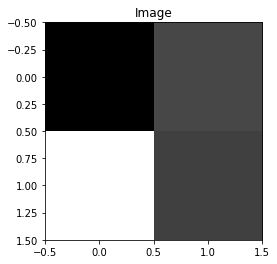

In [18]:
image = image = np.random.uniform(low=0, high=255, size=(2,2)).astype(int)
plt.imshow(image, cmap='gray')
plt.title('Image')
plt.show()

Step 2: flattening image into vector (for convenience). Calculation of sufficient nuber of qubits.

In [19]:
input_im = image.copy().flatten()
input_im = np.interp(input_im, (0, 255), (0, np.pi/2))
coord_q_num = int(np.ceil(math.log(len(input_im), 2)))

Step 3: quantum circuit building.

In [20]:
color = QuantumRegister(1, 'color')
coordinate = QuantumRegister(coord_q_num, 'coordinate')
cr = ClassicalRegister(3, 'c')
qc = QuantumCircuit(coordinate,color, cr)
qc.h(coordinate)
for i, pixel in enumerate(input_im):
    to_not = "{0:b}".format(i).zfill(2)
    for j, bit in enumerate(to_not):
        if int(bit):
            qc.x(j)
    qc.cry(pixel,0,2)
    qc.cx(0,1)
    qc.cry(-pixel,1,2)
    qc.cx(0,1)
    qc.cry(pixel,1,2)
    if i!=len(input_im)-1:
        for j, bit in enumerate(to_not):
            if int(bit):
                qc.x(j)
        qc.barrier()
qc.swap(0,1)
qc.measure(list(range(qc.num_qubits)), list(range(cr.size)))

Circuit drawing

In [21]:
qc.draw()

<pre style="word-wrap: normal;white-space: pre;background: #fff0;line-height: 1.1;font-family: &quot;Courier New&quot;,Courier,monospace">              ┌───┐                                                         ░ »
coordinate_0: ┤ H ├───────■─────────■────────────────────■──────────────────░─»
              ├───┤       │       ┌─┴─┐                ┌─┴─┐                ░ »
coordinate_1: ┤ H ├───────┼───────┤ X ├───────■────────┤ X ├───────■────────░─»
              └───┘┌──────┴──────┐└───┘┌──────┴───────┐└───┘┌──────┴──────┐ ░ »
     color_0: ─────┤ Ry(0.08624) ├─────┤ Ry(-0.08624) ├─────┤ Ry(0.08624) ├─░─»
                   └─────────────┘     └──────────────┘     └─────────────┘ ░ »
         c: 3/════════════════════════════════════════════════════════════════»
                                                                              »
«                                                                             »
«coordinate_0: ───────────■─────────■───────────────────■─────────────────────»
«              ┌───┐      │       ┌─┴─┐               ┌─┴─┐              ┌───┐»
«coordinate_1: ┤ X ├──────┼───────┤ X ├───────■───────┤ X ├──────■───────┤ X ├»
«              └───┘┌─────┴──────┐└───┘┌──────┴──────┐└───┘┌─────┴──────┐└───┘»
«     color_0: ─────┤ Ry(0.3388) ├─────┤ Ry(-0.3388) ├─────┤ Ry(0.3388) ├─────»
«                   └────────────┘     └─────────────┘     └────────────┘     »
«         c: 3/═══════════════════════════════════════════════════════════════»
«                                                                             »
«               ░ ┌───┐                                           ┌───┐      ░ »
«coordinate_0: ─░─┤ X ├──────■─────────■───────────────────■──────┤ X ├──────░─»
«               ░ └───┘      │       ┌─┴─┐               ┌─┴─┐    └───┘      ░ »
«coordinate_1: ─░────────────┼───────┤ X ├───────■───────┤ X ├──────■────────░─»
«               ░      ┌─────┴──────┐└───┘┌──────┴──────┐└───┘┌─────┴──────┐ ░ »
«     color_0: ─░──────┤ Ry(0.9856) ├─────┤ Ry(-0.9856) ├─────┤ Ry(0.9856) ├─░─»
«               ░      └────────────┘     └─────────────┘     └────────────┘ ░ »
«         c: 3/════════════════════════════════════════════════════════════════»
«                                                                              »
«              ┌───┐                                                  ┌─┐   
«coordinate_0: ┤ X ├─────■────────■─────────────────■───────────────X─┤M├───
«              ├───┤     │      ┌─┴─┐             ┌─┴─┐             │ └╥┘┌─┐
«coordinate_1: ┤ X ├─────┼──────┤ X ├──────■──────┤ X ├─────■───────X──╫─┤M├
«              └───┘┌────┴─────┐└───┘┌─────┴─────┐└───┘┌────┴─────┐┌─┐ ║ └╥┘
«     color_0: ─────┤ Ry(π/10) ├─────┤ Ry(-π/10) ├─────┤ Ry(π/10) ├┤M├─╫──╫─
«                   └──────────┘     └───────────┘     └──────────┘└╥┘ ║  ║ 
«         c: 3/═════════════════════════════════════════════════════╩══╩══╩═
«                                                                   2  0  1 </pre>

Step 4: quantum circuit execution, measurments' interpretation

In [22]:
def simulate(qc, input_im, shots=10000, print_data=True):    
    aer_sim = Aer.get_backend('aer_simulator')
    t_qc = transpile(qc, aer_sim)
    qobj = assemble(t_qc, shots=shots)
    result = aer_sim.run(qobj).result()
    counts = result.get_counts(qc)
    if print_data:
        print(counts)
        plot_histogram(counts)
        plt.show()
    nums = []
    for iter in range(len(input_im)):
        num = []
        for item in counts.items():
            if int(item[0][1:], 2)==iter:
                num.append((int(item[0][0], 2), item[1]))
        nums.append(num)
    colors = []
    for num in nums:
        if len(num)==2:
            if num[0][0] == 0:
                color = np.arccos((num[0][1]/(num[0][1]+num[1][1]))**(1/2))
                colors.append(color)
            else:
                color = np.arccos((num[1][1]/(num[0][1]+num[1][1]))**(1/2))
                colors.append(color)
        else:
            if num[0][0] == 0:
                colors.append(0)
            else:
                colors.append(np.pi/2)
    output_im = np.interp(colors, (0, np.pi/2), (0, 255)).astype(int)
    print(output_im, '\n', image.copy().flatten())
    return output_im

Input and measured images comparison

In [23]:
def plot_to_compare(output_im, input_im):
    plt.imshow(output_im.reshape(2,2), cmap = 'gray')
    plt.title('measured image')
    plt.show()
    plt.imshow(input_im.reshape(2,2), cmap = 'gray')
    plt.title('real image')
    plt.show()

[168 139 204 255] 
 [168 140 204 253]


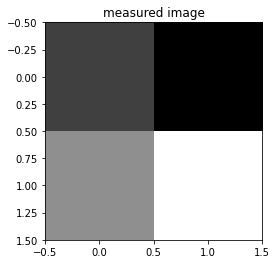

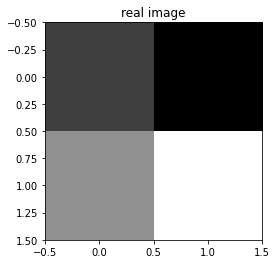

In [15]:
output_im = simulate(qc, input_im, print_data=False)
plot_to_compare(output_im, input_im)

# Flip Horizontal

In [19]:
color = QuantumRegister(1, 'color')
coordinate = QuantumRegister(2, 'coordinate')
cr = ClassicalRegister(3, 'c')
qc = QuantumCircuit(coordinate,color, cr)
qc.h(0)
qc.h(1)
qc.swap(0,1)
for i, pixel in enumerate(input_im):
    to_not = "{0:b}".format(i).zfill(2)
    for j, bit in enumerate(to_not):
        if int(bit):
            qc.x(j)
    if to_not[0]:
        qc.x(0)
    qc.cry(pixel,0,2)
    qc.cx(0,1)
    qc.cry(-pixel,1,2)
    qc.cx(0,1)
    qc.cry(pixel,1,2)
    for j, bit in enumerate(to_not):
        if int(bit):
            qc.x(j)
    if to_not[0]:
        qc.x(0)
        qc.barrier()
qc.swap(0,1)
for i in range(len(input_im)-1):
    qc.measure(i, i)
# qc.draw()

{'010': 1617, '111': 89, '000': 2022, '011': 2413, '110': 911, '001': 894, '101': 1595, '100': 459}


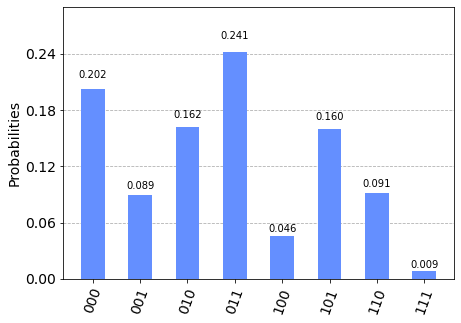

[ 72 150 104  30] 
 [152  71  28 105]


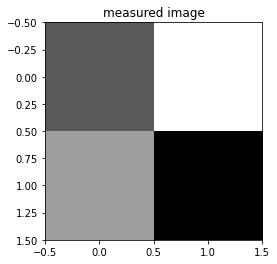

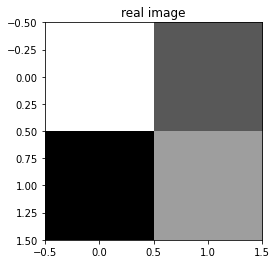

In [20]:
output_im = simulate(qc, input_im)
plot_to_compare(output_im, input_im)

# Flip vertical

In [21]:
color = QuantumRegister(1, 'color')
coordinate = QuantumRegister(2, 'coordinate')
cr = ClassicalRegister(3, 'c')
qc = QuantumCircuit(coordinate,color, cr)
qc.h(0)
qc.h(1)
qc.swap(0,1)
for i, pixel in enumerate(input_im):
    to_not = "{0:b}".format(i).zfill(2)
    for j, bit in enumerate(to_not):
        if int(bit):
            qc.x(j)
    if to_not[1]:
        qc.x(1)
    qc.cry(pixel,0,2)
    qc.cx(0,1)
    qc.cry(-pixel,1,2)
    qc.cx(0,1)
    qc.cry(pixel,1,2)
    for j, bit in enumerate(to_not):
        if int(bit):
            qc.x(j)
    if to_not[1]:
        qc.x(1)
        qc.barrier()
qc.swap(0,1)
for i in range(len(input_im)-1):
    qc.measure(i, i)


{'001': 1577, '010': 867, '000': 2436, '011': 2135, '110': 1577, '111': 452, '101': 881, '100': 75}


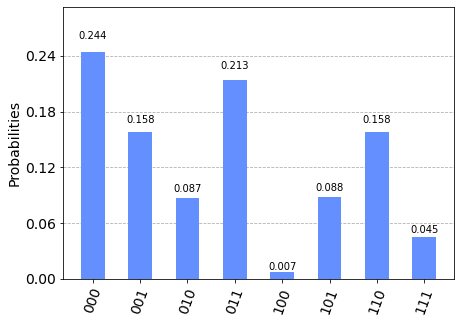

[ 28 104 151  70] 
 [152  71  28 105]


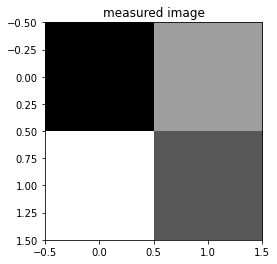

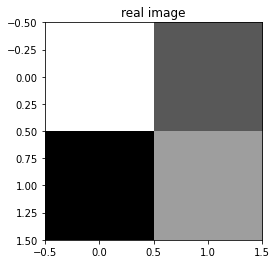

In [22]:
output_im = simulate(qc, input_im, 10000)
plot_to_compare(output_im, input_im)

# 4x4image (multicontrol rotation from https://arxiv.org/pdf/quant-ph/9503016.pdf
# workable solution is from https://github.com/Qiskit/qiskit-terra/issues/5810)

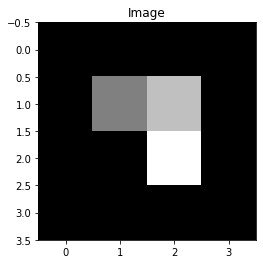

In [23]:
image = np.array([0, 0, 0, 0,
                  0, 100, 150, 0,
                  0, 0, 200, 0,
                  0, 0, 0, 0]).reshape(4,4)
plt.imshow(image, cmap='gray')
plt.title('Image')
plt.show()
input_im = image.flatten()
input_im = np.interp(input_im, (0, 255), (0, np.pi/2))

In [24]:
from qiskit.circuit.library.standard_gates.ry import RYGate
qr = QuantumRegister(5)
color = qr[4]
coordinate = qr[:4]
cr = ClassicalRegister(5, 'c')
qc = QuantumCircuit(qr, cr)

# qc.swap(0,3)
# qc.swap(1,2)

for i in range(4):
    qc.h(i)
for i, pixel in enumerate(input_im):
    to_not = "{0:b}".format(i).zfill(4)
    for j, bit in enumerate(to_not):
        if int(bit):
            qc.x(j)
    qc.barrier()
# either this rotation:
#     qc.mcry(2*pixel, coordinate, color)
# or this:
#------------------------------------
    c3ry = RYGate(2*pixel).control(4)
    qc.append(c3ry, [0, 1, 2, 3, 4])
#------------------------------------
# PROBLEM: why pixel-angle is not pi/2 but has to be pi/2? The power of amount coordinate-qubits?
# PROBLEM: why in both built-in funtionss we have to double anlge?

# the following does not work, IDK why...
#     pixel = pixel/8
#     qc.cry(pixel,3,4)
#     qc.cx(3,2)
#     qc.cry(-pixel,2,4)
#     qc.cx(3,2)
#     qc.cry(pixel,2,4)
#     qc.cx(2,1)
#     qc.cry(-pixel,1,4)
#     qc.cx(3,1)
#     qc.cry(pixel,1,4)
#     qc.cx(2,1)
#     qc.cry(-pixel,1,4)
#     qc.cx(3,1)
#     qc.cry(pixel,1,4)
#     qc.cx(1,0)
#     qc.cry(-pixel,0,4)
#     qc.cx(3,0)
#     qc.cry(pixel,0,4)
#     qc.cx(2,0)
#     qc.cry(-pixel,0,4)
#     qc.cx(3,0)
#     qc.cry(pixel,0,4)
#     qc.cx(1,0)
#     qc.cry(-pixel,0,4)
#     qc.cx(3,0)
#     qc.cry(pixel,0,4)
#     qc.cx(2,0)
#     qc.cry(-pixel,0,4)
#     qc.cx(3,0)
#     qc.cry(pixel,0,4)
#     qc.barrier()
#     qc.cx(2,0)
#     qc.cry(pixel,3,4)
#     qc.cx(0,3)
#     qc.cry(-pixel,3,4)
#     qc.cx(1,3)
#     qc.cry(pixel,3,4)
#     qc.cx(2,3)
#     qc.cry(-pixel,3,4)
#     qc.cx(0,3)
#     qc.cry(pixel,3,4)
    
    
    if i!=len(input_im)-1:
        for j, bit in enumerate(to_not):
            if int(bit):
                qc.x(j)
        qc.barrier()
                    
qc.swap(0,3)
qc.swap(1,2)
        
for i in range(5):
    qc.measure(i, i)

# qc.draw()

In [25]:
def plot_to_compare(output_im, input_im):
    plt.imshow(output_im.reshape(4,4), cmap = 'gray')
    plt.title('measured image')
    plt.show()
    plt.imshow(input_im.reshape(4,4), cmap = 'gray')
    plt.title('real image')
    plt.show()

[  0   0   0   0   0 101 149   0   0   0 199   0   0   0   0   0] 
 [  0   0   0   0   0 100 150   0   0   0 200   0   0   0   0   0]


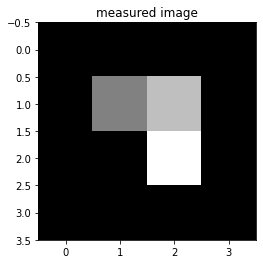

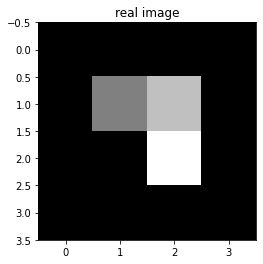

In [27]:
output_im = simulate(qc, input_im, 100000, print_data=False)
plot_to_compare(output_im, input_im)

# Flipping coordinate

In [28]:
from qiskit.circuit.library.standard_gates.ry import RYGate
qr = QuantumRegister(5)
color = qr[4]
coordinate = qr[:4]
cr = ClassicalRegister(5, 'c')
qc = QuantumCircuit(qr, cr)

# first swap to get normal normal in the end
qc.swap(0,3)
qc.swap(1,2)
#second swap to flip image coordinates
qc.swap(0,2)
qc.swap(1,3)

for i in range(4):
    qc.h(i)
for i, pixel in enumerate(input_im):
    to_not = "{0:b}".format(i).zfill(4)
    for j, bit in enumerate(to_not):
        if int(bit):
            qc.x(j)
    qc.barrier()

    c3ry = RYGate(2*pixel).control(4)
    qc.append(c3ry, [0, 1, 2, 3, 4])    
    
    if i!=len(input_im)-1:
        for j, bit in enumerate(to_not):
            if int(bit):
                qc.x(j)
        qc.barrier()

# revert SECOND swap
qc.swap(1,3)
qc.swap(0,2)
# revert FIRST swap
qc.swap(0,3)
qc.swap(1,2)
# if we change order if revert will anything change? In this example NO, but, who knows?..
        
for i in range(5):
    qc.measure(i, i)


[  0   0   0   0   0 100   0   0   0 150 199   0   0   0   0   0] 
 [  0   0   0   0   0 100 150   0   0   0 200   0   0   0   0   0]


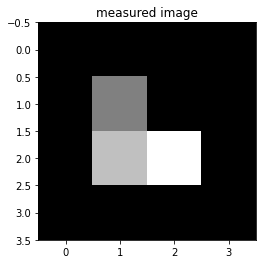

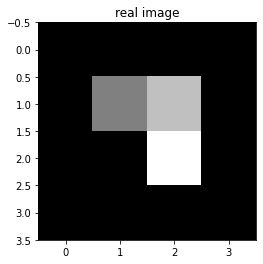

In [29]:
output_im = simulate(qc, input_im, 100000, print_data=False)
plot_to_compare(output_im, input_im)

# Rotations

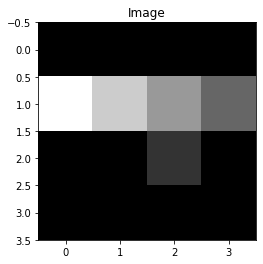

In [30]:
image = np.array([0, 0, 0, 0,
                  250, 200, 150, 100,
                  0, 0, 50, 0,
                  0, 0, 0, 0]).reshape(4,4)
plt.imshow(image, cmap='gray')
plt.title('Image')
plt.show()
input_im = image.flatten()
input_im = np.interp(input_im, (0, 255), (0, np.pi/2))

In [31]:
from qiskit.circuit.library.standard_gates.ry import RYGate
def rotate_circ(rot_ang=None):
    qr = QuantumRegister(5)
    color = qr[4]
    coordinate = qr[:4]
    cr = ClassicalRegister(5, 'c')
    qc = QuantumCircuit(qr, cr)
            
    qc.swap(0,3)
    qc.swap(1,2)

    for i in range(4):
        qc.h(i)
        
    for i, pixel in enumerate(input_im):
        to_not = "{0:b}".format(i).zfill(4)
        for j, bit in enumerate(to_not):
            if int(bit):
                qc.x(j)
        qc.barrier()
        
        c3ry = RYGate(2*pixel).control(4)
        qc.append(c3ry, [0, 1, 2, 3, 4])    

        if i!=len(input_im)-1:
            for j, bit in enumerate(to_not):
                if int(bit):
                    qc.x(j)
            qc.barrier()

    qc.swap(0,3)
    qc.swap(1,2)
    
    if rot_ang == 90:
        qc.x(2)
        qc.x(3)
        qc.swap(0,3)
        qc.swap(1,2)
        
    if rot_ang == 180:
        qc.x(0)
        qc.x(1)
        qc.x(2)
        qc.x(3)
              
    if rot_ang == 270:
        qc.swap(0,3)
        qc.swap(1,2)
        qc.x(2)
        qc.x(3)
        
    for i in range(5):
        qc.measure(i, i)
        
    return qc

ROTATION FOR 90 DEGREES
[  0 249   0   0   0 149  47   0   0 197   0   0   0  99   0   0] 
 [  0   0   0   0 250 200 150 100   0   0  50   0   0   0   0   0]


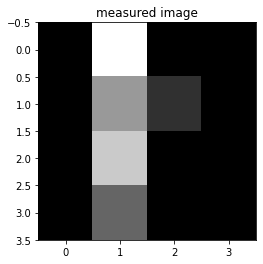

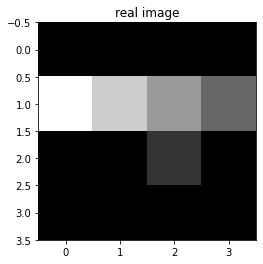

ROTATION FOR 180 DEGREES
[  0   0   0   0   0  48   0   0 100 150 199 252   0   0   0   0] 
 [  0   0   0   0 250 200 150 100   0   0  50   0   0   0   0   0]


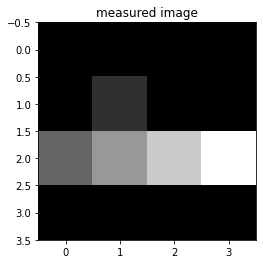

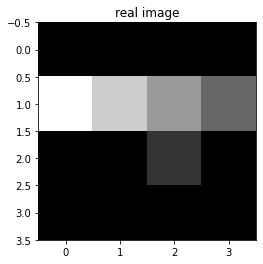

ROTATION FOR 270 DEGREES
[  0   0  98   0   0   0 201   0   0  49 151   0   0   0 249   0] 
 [  0   0   0   0 250 200 150 100   0   0  50   0   0   0   0   0]


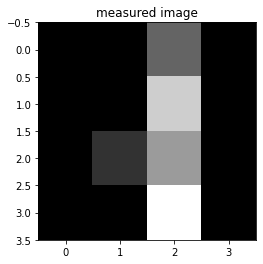

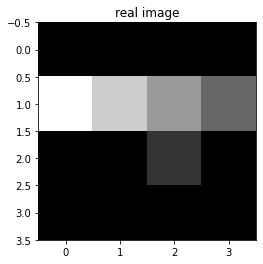

In [32]:
for theta in [90, 180, 270]:
    print('ROTATION FOR {} DEGREES'.format(theta))
    qc = rotate_circ(theta)
    output_im = simulate(qc, input_im, 100000, 0)
    plot_to_compare(output_im, input_im)

# Multi-Channel Representation for Quantum Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


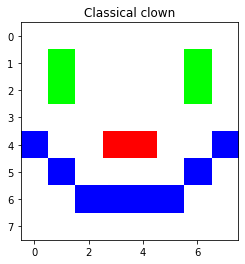

In [33]:
image = np.zeros((8,8,3))
image[:,:,0] = np.array(
           [255, 255, 255, 255, 255, 255, 255, 255,
            255,   0, 255, 255, 255, 255,   0, 255,
            255,   0, 255, 255, 255, 255,   0, 255,
            255, 255, 255, 255, 255, 255, 255, 255,
              0, 255, 255, 255, 255, 255, 255,   0,
            255,   0, 255, 255, 255, 255,   0, 255,
            255, 255, 0,   0,   0,   0, 255, 255,
            255, 255, 255, 255, 255, 255, 255, 255]).reshape(8,8)

image[:,:,1] = np.array(
           [255, 255, 255, 255, 255, 255, 255, 255,
            255, 255, 255, 255, 255, 255, 255, 255,
            255, 255, 255, 255, 255, 255, 255, 255,
            255, 255, 255, 255, 255, 255, 255, 255,
              0, 255, 255,   0,   0, 255, 255,   0,
            255,   0, 255, 255, 255, 255,   0, 255,
            255, 255, 0,   0,   0,   0,255, 255,
            255, 255, 255, 255, 255, 255, 255, 255]).reshape(8,8)

image[:,:,2] = np.array(
           [255, 255, 255, 255, 255, 255, 255, 255,
            255,   0, 255, 255, 255, 255,   0, 255,
            255,   0, 255, 255, 255, 255,   0, 255,
            255, 255, 255, 255, 255, 255, 255, 255,
            255, 255, 255,   0,   0, 255, 255, 255,
            255, 255, 255, 255, 255, 255, 255, 255,
            255, 255, 255, 255, 255, 255, 255, 255,
            255, 255, 255, 255, 255, 255, 255, 255]).reshape(8,8)

plt.imshow(image.reshape(8,8,3))
plt.title('Classical clown')
plt.show()
            

In [34]:
import math
def params(image):
    xqbits = math.log(image.shape[0],2)
    yqbits = math.log(image.shape[1],2)
    return int(xqbits), int(yqbits)
    
def rgb_circ(image):
    xqbit, yqbit = params(image)
    qr = QuantumRegister(xqbit + yqbit + 3) #3 stands for RGB qubits
    color = qr[xqbit + yqbit:]
    coordinate = qr[:xqbit + yqbit]
    cr = ClassicalRegister(xqbit + yqbit + 3, 'c')
    qc = QuantumCircuit(qr, cr)
    
    for k in range(int(np.floor((xqbit + yqbit)/2))):
        qc.swap(k,xqbit + yqbit - 1 - k)
        
    for i in range(xqbit + yqbit):
        qc.h(i)
    
    for layer_num, input_im in enumerate(image.T):
        input_im = input_im.flatten()
        input_im = np.interp(input_im, (0, 255), (0, np.pi/2))
        
        for i, pixel in enumerate(input_im):
            arr = list(range(xqbit + yqbit))
            arr.append(int(xqbit + yqbit + layer_num))
            cMry = RYGate(2*pixel).control(xqbit + yqbit)
            
            to_not = "{0:b}".format(i).zfill(xqbit + yqbit)
            for j, bit in enumerate(to_not):
                if int(bit):
                    qc.x(j)
            qc.barrier()
            qc.append(cMry, arr)  

            if i!=len(input_im)-1 or layer_num!=2:
                for j, bit in enumerate(to_not):
                    if int(bit):
                        qc.x(j)
                qc.barrier()
    
    for k in range(int(np.floor((xqbit + yqbit)/2))):
        qc.swap(k, xqbit + yqbit - 1 - k)
    
    qc.swap(-1, -3)

    qc.barrier()
    for i in range(xqbit + yqbit + 3):
        qc.measure(i, i)
    
    return qc

In [35]:
def run_qc(qc, shots = 1000):    
    aer_sim = Aer.get_backend('aer_simulator')
    t_qc = transpile(qc, aer_sim)
    qobj = assemble(t_qc, shots=shots)
    result = aer_sim.run(qobj).result()
    counts = result.get_counts(qc)
    return counts

In [36]:
qc = rgb_circ(image)
counts = run_qc(qc)

In [37]:
def reconstruct_rgb(image, counts, to_print = True):
    output_ims = []
    for layer_num, input_im in enumerate(image.T):
        input_im = input_im.flatten()
        nums = []
        for iter in range(len(input_im)):
            flag = 0
            num = []
            for item in counts.items():
                if int(item[0][3:], 2)==iter:
                    num.append((int(item[0][layer_num], 2), item[1]))
            nums.append(num)
        for l, num in enumerate(nums):
            my_set = {x[0] for x in num}
            nums[l] = [(i,sum(x[1] for x in num if x[0] == i)) for i in my_set]
        colors = []
    #     print(nums)
        for num in nums:
            if len(num)==2:
                if num[0][0] == 0:
                    color = np.arccos((num[0][1]/(num[0][1]+num[1][1]))**(1/2))
                    colors.append(color)
                else:
                    color = np.arccos((num[1][1]/(num[0][1]+num[1][1]))**(1/2))
                    colors.append(color)
            else:
                if num[0][0] == 0:
                    colors.append(0)
                else:
                    colors.append(np.pi/2)
        output_im = np.interp(colors, (0, np.pi/2), (0, 255)).astype(int)
        if to_print:
            print(output_im, '\n', (image.T)[layer_num].copy().flatten())
        output_ims.append(output_im.reshape(image[:,:,0].shape))
    
    return np.array(output_ims).T

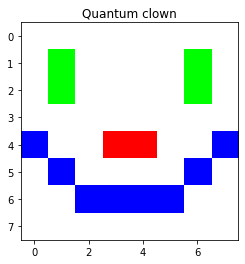

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


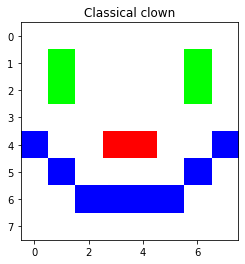

In [38]:
output_ims = reconstruct_rgb(image, counts, to_print = False)
plt.imshow(output_ims)
plt.title('Quantum clown')
plt.show()
plt.title('Classical clown')
plt.imshow(image)
plt.show()

# with mixed colors

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


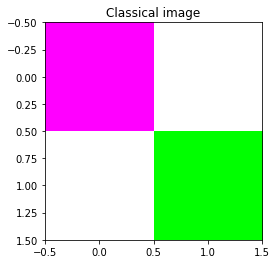

In [40]:
image = np.zeros((2,2,3))
image[:,:,0] = np.array(
           [255, 10,
            250,   0]).reshape(2,2)

image[:,:,1] = np.array(
           [0, 100,
            150, 255]).reshape(2,2)

image[:,:,2] = np.array(
           [255, 200,
            10,   0]).reshape(2,2)

plt.imshow(image.reshape(2,2,3))
plt.title('Classical image')
plt.show()

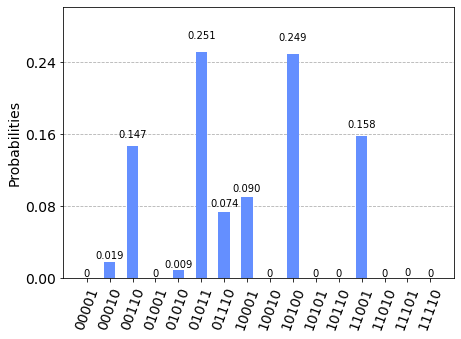

[255 249   8   0] 
 [255. 250.  10.   0.]
[  0 149  99 255] 
 [  0. 150. 100. 255.]
[255  10 199   0] 
 [255.  10. 200.   0.]


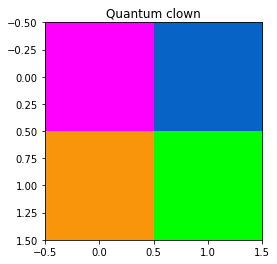

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


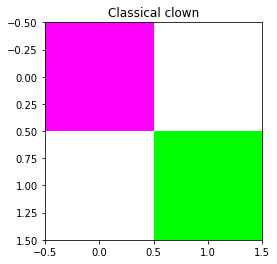

In [41]:
qc = rgb_circ(image)
counts = run_qc(qc, shots = 100000)
plot_histogram(counts)
plt.show()
output_ims = reconstruct_rgb(image, counts, to_print = True)
plt.imshow(output_ims)
plt.title('Quantum clown')
plt.show()
plt.title('Classical clown')
plt.imshow(image)
plt.show()

# Blending 2 images (49/177)

# Image comparison (52/177)